In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F
import sys
#import chainer.functions.evaluation.recall as rec
import csv
from pprint import pprint 

plt.style.use('ggplot')


In [2]:
# 確率的勾配降下法におけるミニバッチ数
batchsize = 20

# 学習の繰り返し回数
n_epoch = 1

# 中間層の数
n_units = 20


#=================================================
# csvファイルからデータを取り出し、listに格納
def set_data():

        filename = "../../../data/secondary_selection/input_data2_2"
        
        f = open('%s.csv' % filename, 'rU')
        data = csv.reader(f)

        data_set = []
        target_set = []
        for line in data:
                data_set.append(line[1:16])
                target_set.append(line[16])
        f.close()
        np_dataSet = np.array(data_set, dtype=np.float32)
        np_targetSet = np.array(target_set, dtype=np.int32)
        return np_dataSet, np_targetSet

#=================================================

data, target = set_data()

# <!--- start_debug
#print data.shape
#print target.shape
#       end_debug ----> 


# 学習用データをN個、検証用データを残りの個数と設定
# Nの値は暫定的なもの
N = 300
x_train, x_test = np.split( data, [N])  
y_train, y_test = np.split( target, [N]) 
N_test = y_test.size
#print data
#print target



In [3]:
# 多層パーセプトロンモデルの設定
# 入力 15次元、出力 2次元
model = FunctionSet(l1=F.Linear(15, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, n_units),
                    l4=F.Linear(n_units, 2))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True ):
        x, t = Variable(x_data), Variable(y_data)
        h1 = F.dropout(F.relu(model.l1(x)), ratio=.2, train=train)
        h2 = F.dropout(F.relu(model.l2(h1)), ratio=.2, train=train)
        h3 = F.dropout(F.relu(model.l3(h2)), ratio=.2, train=train)
        y = model.l4(h3)
        # 0/1の2クラス分類なので誤差関数として、ソフトマックス関数
        # を用いて、誤差を導出
   
                                
        #print '-'*50
        #print ' h3'
        #print '-'*50
        #print vars(h3)
                        
        #print '-'*50
        #print ' y'
        #print '-'*50
        #print vars(y)
 
        
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t), F.recall(y, t), F.precision(y, t)



In [4]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

train_loss = []
train_acc= []
test_loss = []
test_acc = []

l1_W = []
l2_W = []
l3_W = []
l4_W = []



epoch 1
train mean loss=0.700922544797, accuracy=0.560000002384
0.666666686535
0.54545456171
0.818181812763
0.642857134342
0.769230782986
0.714285731316
0.833333313465
0.666666686535
0.857142865658
0.375
test  mean loss=0.655867910385, accuracy=0.599999988079


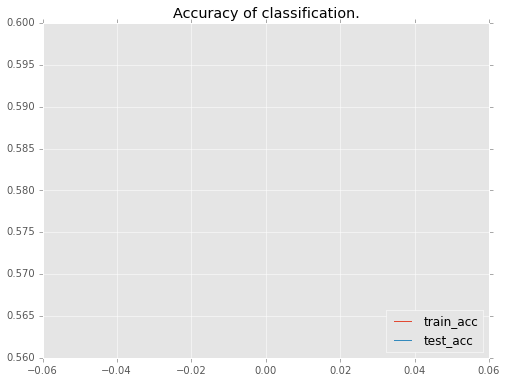

In [5]:

    
# Learning loop
for epoch in xrange(1, n_epoch+1):
        print 'epoch', epoch

        # training
        # N個の順番をランダムに並び替える
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        # 0〜Nまでのデータをバッチサイズごとに使って学習
        for i in xrange(0, N, batchsize):
                x_batch = x_train[perm[i:i+batchsize]]
                y_batch = y_train[perm[i:i+batchsize]]

                # 勾配を初期化
                optimizer.zero_grads()
                # 順伝播させて誤差と精度を算出
                loss, acc, rec, pre = forward(x_batch, y_batch)
                # 誤差逆伝播で勾配を計算
                loss.backward()
                optimizer.update()
                
                #print '-'*50
                #print ' acc'
                #print '-'*50, 
                
                #print vars(acc) 
                #print acc.data
    
                sum_loss += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # 訓練データの誤差と、正解精度を表示
        print 'train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N)
                
        train_loss.append(sum_loss / N)
        train_acc.append(sum_accuracy / N)


        # evaluation
        # テストデータで誤差と、正解精度を算出し汎化性能を確認
        sum_accuracy = 0
        sum_loss     = 0
        for i in xrange(0, N_test, batchsize):
                x_batch = x_test[i:i+batchsize]
                y_batch = y_test[i:i+batchsize]

                # 順伝播させて誤差と精度を算出
                loss, acc, rec, pre = forward(x_batch, y_batch, train=False)
          
                #print( cuda.to_cpu(loss.data))
                print( cuda.to_cpu(rec.data))
                print( cuda.to_cpu(pre.data))
                sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize
                

        # テストデータでの誤差と、正解精度を表示
        print 'test  mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test)
        test_loss.append( sum_loss / N_test)
        test_acc.append( sum_accuracy / N_test)
        

        
        # 学習したパラメーターを保存
        l1_W.append(model.l1.W)
        l2_W.append(model.l2.W)
        l3_W.append(model.l3.W)
        l4_W.append(model.l4.W)
        
        #l1_W = np.append( l1_W, model.l1.W)
        
                      
        #pprint(vars(model.l1))
        #pprint(model.l1.W[0:2])

        # 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of classification.")
plt.plot()

is_done = True

In [59]:
# 学習したパラメータを出力
#print l1_W

#print l2_W
#print l3_W

l1 = l1_W[0].T
l2 = l2_W[0].T
l3 = l3_W[0].T
l4 = l4_W[0].T


param = l1.dot(l2).dot(l3).dot(l4)

print param

[[-0.02798676 -0.17780033]
 [ 0.247187    0.10619548]
 [ 0.27062398 -0.05198815]
 [-0.01262167 -0.25728923]
 [ 0.53304344  0.21175373]
 [-0.11098442  0.12040781]
 [-0.21507969 -0.11726713]
 [-0.47144216  0.0398447 ]
 [-0.16562846 -0.2208975 ]
 [ 0.69890964  0.43969148]
 [-0.24674706  0.07255423]
 [ 0.24821234 -0.06143026]
 [-0.02372829  0.29510057]
 [ 0.05651759  0.24108914]
 [-0.36914977  0.33070898]]
